# Importing libraries

In [1]:
import cv2
import io
import jupyter_bbox_widget as jbw
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import requests

# Loading image

In [2]:
original_img = cv2.imread('image.jpg')

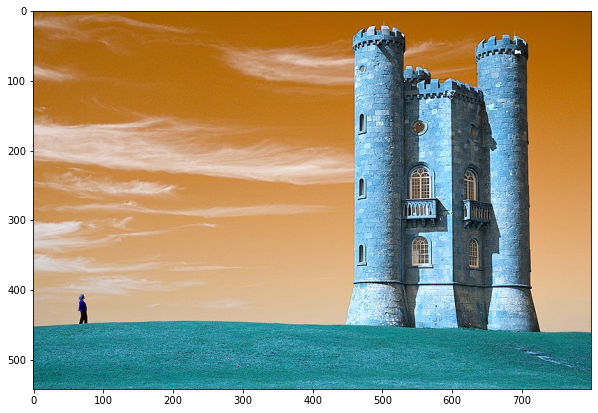

In [3]:
plt.figure(figsize=(10, 8))
plt.imshow(original_img)
plt.show()

# Carving

## Finding energy map

In [4]:
def get_energy(gray_img):
    # Kernel for computing gradient w.r.t x
    kx = np.array(
      [[-0.5, 0., 0.5],
       [-1.,  0., 1.],
       [-0.5, 0., 0.5]]
    )

    # Kernel for computing gradient w.r.t y
    ky = np.array(
      [[-0.5, -1., -0.5],
       [0.,   0., 0.],
       [0.5,  1., 0.5]]
    )

    dx = cv2.filter2D(gray_img, -1, kx)
    dy = cv2.filter2D(gray_img, -1, ky)

    energy = dx**2 + dy**2
    return energy.astype(np.float64)

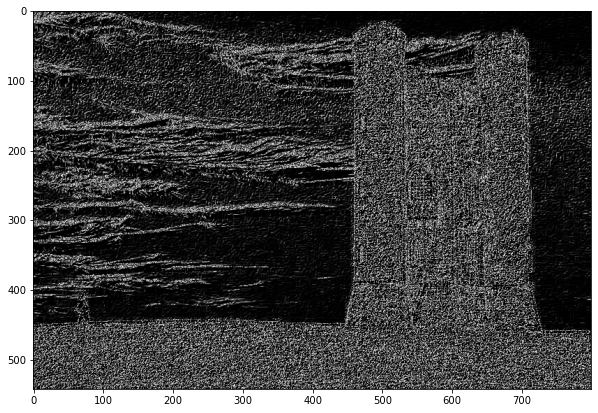

In [5]:
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
energy = get_energy(gray_img)
plt.figure(figsize=(10, 8))
plt.imshow(energy, cmap='gray')
plt.show()

## Finding min seam

In [6]:
class Seam:
    """Represent the seams to be used for other functions.
    
    Each seam holds the size of the image (num_rows and num_cols) it
    is intended to be applied to. A seam is default to be vertical,
    i.e. from top to bottom.
    
    This class is created to easily change between array form and
    mask form of a seam, and as well as to update the seam.
    """
    def __init__(self, num_rows, num_cols, indices):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.indices = np.asarray(indices)
        
        self._update()
        
    def update(self, new_indices, new_num_rows=None, new_num_cols=None):
        if new_num_rows is not None:
            self.num_rows = new_num_rows
            
        if new_num_cols is not None:
            self.num_cols = new_num_cols
        
        self.indices = new_indices
        
        self._update()
    
    def to_array(self):
        return self.array_form.copy()
    
    def to_mask(self):
        return self.mask_form.copy()
    
    def _update(self):
        # Array form of the seam
        self.array_form = np.asarray(self.indices)
        
        # Create mask form of the seam
        self.mask_form = np.zeros((self.num_rows, self.num_cols), dtype=bool)
        self.mask_form[np.arange(self.num_rows), self.indices] = True

In [7]:
def get_seam(energy):
    """Search for minimum total energy seam from `energy` using dynamic
    programming.
    
    Parameters
    ----------
    energy : np.array
        The energy map of the image.

    Returns
    -------
    Seam
        The minimum seam of the image.
    """

    num_rows, num_cols = energy.shape

    min_downward_energy = np.zeros_like(energy, dtype=np.int64)
    path = np.zeros_like(energy, dtype=np.int64)

    # Initializing
    min_downward_energy[-1, :] = energy[-1, :].copy()
    base_idx = np.arange(-1, num_cols-1)

    for i in reversed(range(num_rows-1)):
        # These arrays store the values that are below left, below middle, or
        # below right to the values in the ith row
        lefts = np.hstack([np.inf, min_downward_energy[i+1, :-1]])
        middles = min_downward_energy[i+1]
        rights = np.hstack([min_downward_energy[i+1, 1:], np.inf])

        # The indices of the minimum elements among the below left, middle and right
        # of each element in the ith row
        min_idx = np.argmin([lefts, middles, rights], axis=0) + base_idx

        # Updates
        min_downward_energy[i] = energy[i] + min_downward_energy[i+1, min_idx]
        path[i] = min_idx

    # Extracting minimum seam from path
    indices = []
    j = np.argmin(min_downward_energy[0, :])
    i = 0
    while i < num_rows:
        indices.append(j)
        j = path[i, j]
        i += 1

    seam = Seam(num_rows, num_cols, indices)
    return seam

### Utilities

In [8]:
def add_seam_to_image(img, seam):
    """Return a new image with all pixels in the seam stored in `seam` turned
    into magenta.
    
    Parameters
    ----------
    img : np.array
        The image, either grayscale or colored
    seam : Seam
        The seam to be added
        
    Returns
    -------
    np.array
        The new image with seam added. If the input `img` is grayscale,
        the returned image is automatically converted to colored image.
    """
    
    with_seam = img.copy()
    # Convert grayscale image to RGB space
    if len(img.shape) == 2:
        with_seam = np.stack([with_seam] * 3, axis=2)
        
    seam_mask = seam.to_mask()
    magenta = np.stack([seam_mask * 255, seam_mask * 0, seam_mask * 255], axis=2)
    with_seam = with_seam * (1 - seam_mask[..., np.newaxis]) + magenta
    return with_seam.astype(np.uint8)

In [9]:
def bgr_rgb(img):
    """Switch back and forth between BGR-formatted and RGB-formatted image
    """
    res = np.empty_like(img)
    res[:, :, 0] = img[:, :, 2].copy()
    res[:, :, 1] = img[:, :, 1].copy()
    res[:, :, 2] = img[:, :, 0].copy()
    return res

### Testing

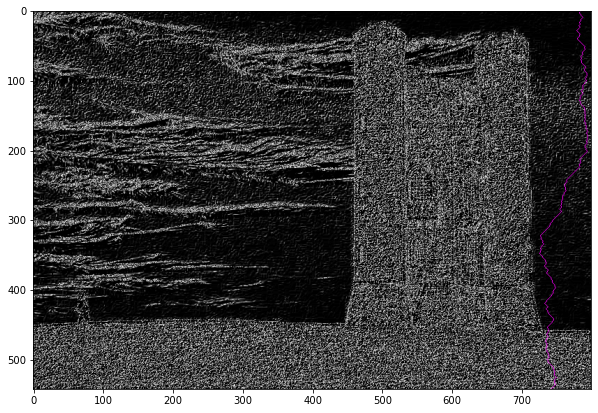

In [10]:
# Find minimum seam
seam = get_seam(energy)

# Add the seam to the image
with_seam = add_seam_to_image(energy, seam)

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(with_seam)
plt.show()

## Removing one seam from the image

In [11]:
def remove_seam(img, seam):
    """Remove the seam from image
    
    Parameters
    ----------
    img : np.array
        An image, either in grayscale or colored.
    seam : Seam
        The seam to remove. The seam must have num_rows and num_cols
        equal to the image's num_rows and num_cols
        
    Returns
    -------
    np.array
        The new image with the seam removed. The number of columns of the
        returned image is less than one compared to the input image.
    """

    # Reduce one pixel in column    
    new_shape = list(img.shape)
    new_shape[1] -= 1

    new_img = np.empty(new_shape, dtype=img.dtype)
    num_rows = new_shape[0]
    dim = len(new_shape)
    mask = seam.to_mask()

    # 2D (or grayscale) image
    if dim == 2:
        for i in range(num_rows):
            new_img[i, :] = img[i, :][~mask[i, :]]
    # 3D image
    else:
        for i in range(num_rows):
            new_img[i, :, :] = img[i, :, :][~mask[i, :]]

    return new_img

## Resizing - removing multiple seams

In [12]:
def add_padding_left(img, pad_width):
    """Add a column of white padding to the left of the image
    
    Parameters
    ----------
    img : np.array
        A 3D image.
    pad_width : int
        The width of the padding field.
    
    Returns
    -------
    np.array
    """
    white_padding = np.full(
        shape=(img.shape[0], pad_width, img.shape[2]),
        fill_value=255,
        dtype=with_seam.dtype
    )
    new_img = np.hstack([img, white_padding])
    return new_img

In [13]:
def create_gif_frame(img, seam, original_shape):
    with_seam = add_seam_to_image(img, seam)
            
    # Add a white padding to the right of each resized frame
    with_seam = add_padding_left(with_seam,
                                 pad_width=original_shape[1] - with_seam.shape[1])

    # Encode each frame
    is_success, buffer = cv2.imencode('.jpg', with_seam, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    buffer = io.BytesIO(buffer)
    return buffer

In [14]:
def resize(img, num_seams, axis=1, create_gif=False, gif_file_name=None, include_mask=None, exclude_mask=None):
    """Resize image using seam carving
    
    Parameters:
    -----------
    img : np.array
        A 3D image
    num_seams : int
        Number of seams to remove
    axis : int
        0 to reduce image height, 1 to reduce image width
    create_gif : bool
        Whether to create an animated GIF file of the resizing process
    gif_file_name : str
        GIF file name
    include_mask : np.array
        A boolean mask that marks which pixels to keep in the image
    exclude_mask : np.array
        A boolean mask that marks which pixels to prioritize their removal
    
    Returns
    -------
    np.array
        A resized image
    """
    im = img.copy()
    
    # This is if we're reducing the height of the image
    if axis == 0:
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)

    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
    original_shape = im.shape
    # This stores the frames of the GIF file
    gif_frames = []
    
    if include_mask is None:
        include_mask = np.zeros(gray_im.shape, dtype=bool)
        
    if exclude_mask is None:
        exclude_mask = np.zeros(gray_im.shape, dtype=bool)
    
    for i in range(num_seams):
        energy = get_energy(gray_im)
        
        # Make the exclude_mask low weighted, and make include_mask
        # high weighted
        energy = energy.astype(np.float64)
        energy = energy * ~exclude_mask + -10e10 * exclude_mask
        energy = energy * ~include_mask + 10e10 * include_mask
        seam = get_seam(energy)

        if create_gif:            
            buffer = create_gif_frame(im, seam, original_shape)
            # Open each frame as a PIL.Image and store it
            gif_frames.append(Image.open(buffer))

        # Remove one seam from the image and masks
        im = remove_seam(im, seam)
        include_mask = remove_seam(include_mask, seam)
        exclude_mask = remove_seam(exclude_mask, seam)
        gray_im = remove_seam(gray_im, seam)

    if create_gif:
        # Export as a GIF file
        frame = gif_frames[0]
        frame.save(fp=gif_file_name, format='GIF', append_images=gif_frames, save_all=True, duration=200, loop=0)

    return im if axis == 1 else cv2.rotate(im, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

### Reducing width

In [15]:
%%time
reduced_width = resize(original_img, num_seams=50, axis=1, create_gif=True, gif_file_name='reducing-width.gif')
original_img.shape, reduced_width.shape

CPU times: user 6.28 s, sys: 499 ms, total: 6.78 s
Wall time: 6.76 s


((542, 800, 3), (542, 750, 3))

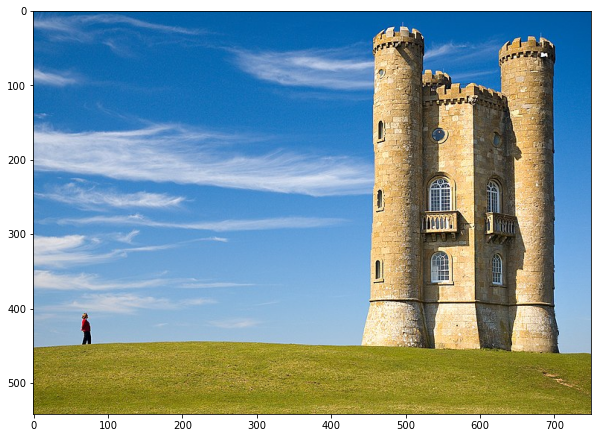

In [16]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_width))
plt.show()

### Reducing height

In [17]:
%%time
reduced_height = resize(original_img, num_seams=50, axis=0, create_gif=True, gif_file_name='reducing-height.gif')
original_img.shape, reduced_height.shape

CPU times: user 7.08 s, sys: 402 ms, total: 7.48 s
Wall time: 7.49 s


((542, 800, 3), (492, 800, 3))

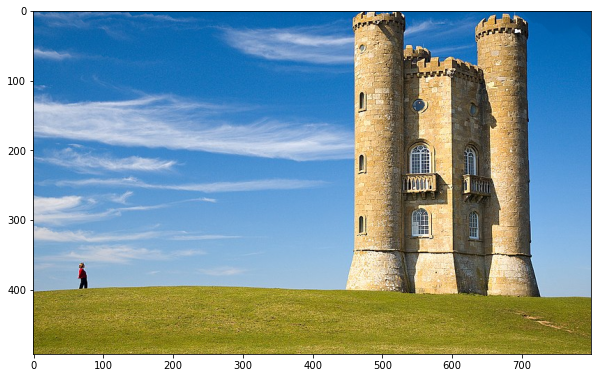

In [18]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_height))
plt.show()

# Creating masks for object

In [19]:
bboxes = [{'x': 60, 'y': 403, 'width': 21, 'height': 50, 'label': 'exclude'},
          {'x': 718, 'y': 29, 'width': 77, 'height': 430, 'label': 'include'}]

In [20]:
# Specifies what pixel to not remove
include_mask = np.zeros(original_img.shape[:2], dtype=bool)
# Specifies what pixel to remove
exclude_mask = np.zeros(original_img.shape[:2], dtype=bool)

for bbox in bboxes:
    x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
    if bbox['label'] == 'include':
        include_mask[y:y+h, x:x+w] = 1
    else:
        exclude_mask[y:y+h, x:x+w] = 1

## Visualizing image with mask

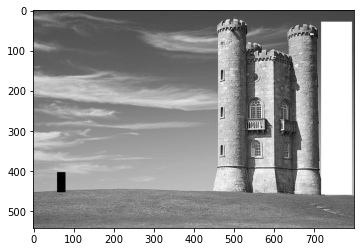

In [21]:
# White for include_mask
with_mask = gray_img * ~include_mask + 255 * include_mask
# Black for exclude_mask
with_mask = with_mask * ~exclude_mask + 0 * exclude_mask
plt.imshow(with_mask, cmap='gray');

## Resizing image with mask

In [22]:
%%time
reduced_width = resize(
    original_img,
    num_seams=100,
    axis=1,
    create_gif=True,
    gif_file_name='reducing-with-mask.gif',
    include_mask=include_mask,
    exclude_mask=exclude_mask
)

CPU times: user 13.6 s, sys: 950 ms, total: 14.5 s
Wall time: 14.7 s


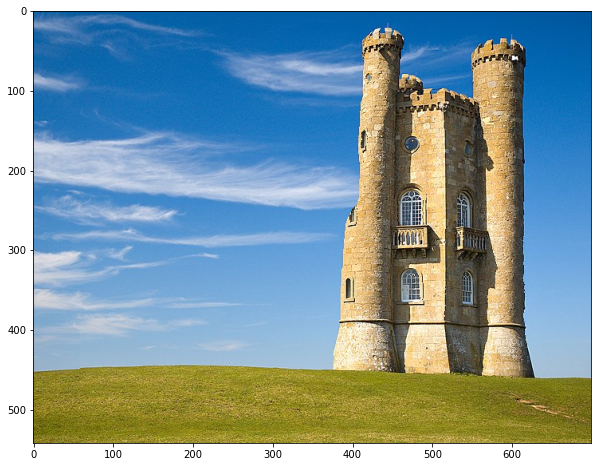

In [23]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_width))
plt.show()

# Enlarging image

To enlarge an image by $k$ seams, first find $k$ seams for removal $s^{(1)}, \dots, s^{(k)}$ (yes, find seams for removal). Then duplicate the seams sequentially, starting from seam $s^{(k)}$ down to seam $s^{(1)}$.

Duplicating a seam $s^{(i)}$ is simply copying $s^{(i)}$ to the right, which pushes the remaining right half of the image (as divided by $s^{(i)}$) one pixel to the right. This means any other seam $s^{(j)}$ $(j \ne i)$ that lies completely, or partially, on the right half of the image needs to be pushed as well. This is because a seam marks the indices of a sequence of pixels that together form the total minimum energy. If we update the image without updating the seam indices, the new pixels no longer sum to minimum energy.

We only pushes the part of a seam $s^{(j)}$ that lies to the right of $s^{(i)}$. To identify which indices to update, we compare the indices of two seams elementwise: $s^{(j)}_k$ is in the right half if $s^{(j)}_k > s^{(i)}_k$. Then update $s^{(j)}_k = s^{(j)}_k + 1$.

In [24]:
def duplicate_seam(img, seam):
    """Duplicate the pixels lie in the seam of the image to the right
    
    Parameters
    ----------
    img : np.array
        A 3D image
    seam : Seam    
        The seam to duplicate
        
    Returns
    -------
    np.array
        New image with the seam duplicated
    """
    h, w, d = img.shape
    new_img = np.empty((h, w+1, d), dtype=img.dtype)
    arr = seam.to_array()
    
    for r in range(h):
        new_img[r, :arr[r], :] = img[r, :arr[r], :]
        new_img[r, arr[r], :] = img[r, arr[r], :]
        new_img[r, arr[r] + 1, :] = img[r, arr[r], :]
        new_img[r, arr[r] + 2:, :] = img[r, arr[r] + 1:, :]
    return new_img

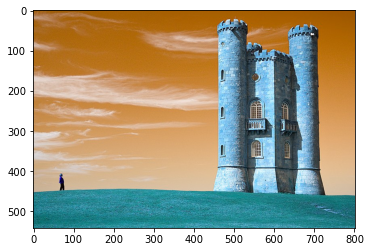

In [25]:
added = duplicate_seam(original_img, seam)
# added.shape
plt.imshow(added)
# plt.imshow(original_img)

In [26]:
def enlarge(img, num_seams):
    """Increase the width of the image by duplicating seams
    
    Parameters
    ----------
    img : np.array
        A 3D image
    num_seams : int
        Number of seams to increase
        
    Returns
    -------
    np.array
        The enlarged image
    """
    
    # Find k seams for removal
    im = img.copy()
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    num_rows, num_cols = gray_img.shape
    seams = []
    for i in range(num_seams):
        seam = get_seam(get_energy(gray_img))
        seams.append(seam)
        remove_seam(gray_img, seam)
    
    while seams:
        seam = seams.pop()
        im = duplicate_seam(im, seam)
        
        # Update indices of other seams
        for other in seams:
            other_array = other.to_array()
            seam_array = seam.to_array()

            other_array[other_array > seam_array] += 1
            other.update(other_array, im.shape[0], im.shape[1])
    return im

CPU times: user 5.19 s, sys: 5.91 ms, total: 5.19 s
Wall time: 5.2 s


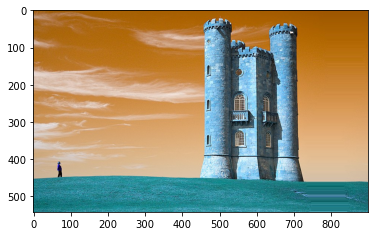

In [27]:
%%time
plt.imshow(enlarge(original_img, 100))

# Remove an object by mask without changing image size

In [28]:
def remove_object(img, mask):
    """Remove an object from the image
    
    Parameters
    ----------
    img : np.array
        A 3D image
    mask : np.array
        A 2D boolean mask that marks the pixels of the object to remove
        
    Returns
    -------
    np.array
        The new image with the same shape as `img`
    """
    
    num_seams = mask.any(axis=0).sum()
    
    # Remove in two stages
    # Stage 1: Remove the object
    tmp = resize(img, num_seams, exclude_mask=mask)
    
    # Stage 2: Enlarge the image
    tmp = enlarge(tmp, num_seams)
    
    return tmp

CPU times: user 2.47 s, sys: 6.34 ms, total: 2.48 s
Wall time: 2.46 s


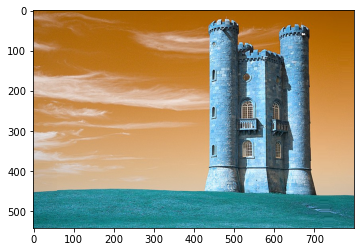

In [29]:
%%time
p = remove_object(original_img, exclude_mask)
plt.imshow(p);